In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

Unzip the dataset stored in your Google Drive.

In [ ]:
!unzip /content/drive/MyDrive/Projects/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/train/0/9687273L.png  
  inflating: archive/train/0/9689906R.png  
 extracting: archive/train/0/9690910L.png  
 extracting: archive/train/0/9690910R.png  
  inflating: archive/train/0/9691359L.png  
  inflating: archive/train/0/9691359R.png  
  inflating: archive/train/0/9692163L.png  
  inflating: archive/train/0/9692604L.png  
  inflating: archive/train/0/9692604R.png  
  inflating: archive/train/0/9692923R.png  
  inflating: archive/train/0/9693364R.png  
  inflating: archive/train/0/9693599L.png  
  inflating: archive/train/0/9693599R.png  
  inflating: archive/train/0/9694101L.png  
  inflating: archive/train/0/9694101R.png  
  inflating: archive/train/0/9695317L.png  
  inflating: archive/train/0/9695317R.png  
  inflating: archive/train/0/9695621L.png  
  inflating: archive/train/0/9695881L.png  
  inflating: archive/train/0/9695881R.png  
  inflating: archive/train/0/9695948L.png  
  inflating: archive/trai

Define paths for training, testing, and validation datasets.

list_of_classes contains the class labels for the dataset.

In [ ]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'
valid_path = '/content/archive/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

We have three datasets for training,testing and validation. Finding length of each dataset.Organizing the file paths and labels into DataFrames, enabling efficient data loading and preprocessing for training and evaluation.

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


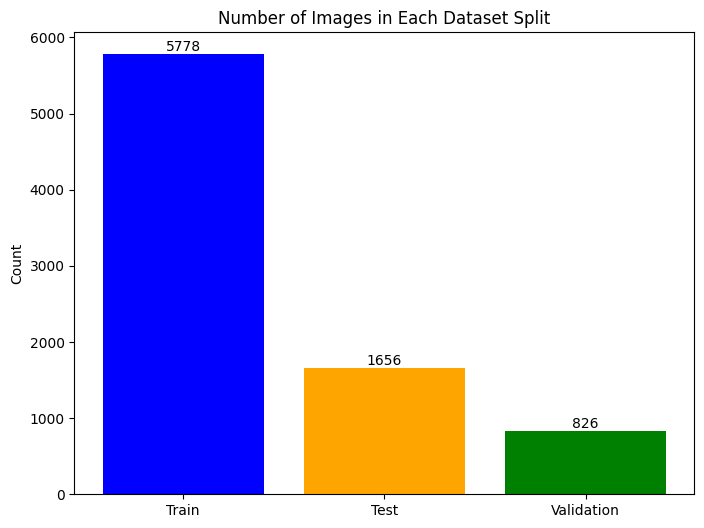

Healthy  has the most images=  2286   Severe  has the least images=  173


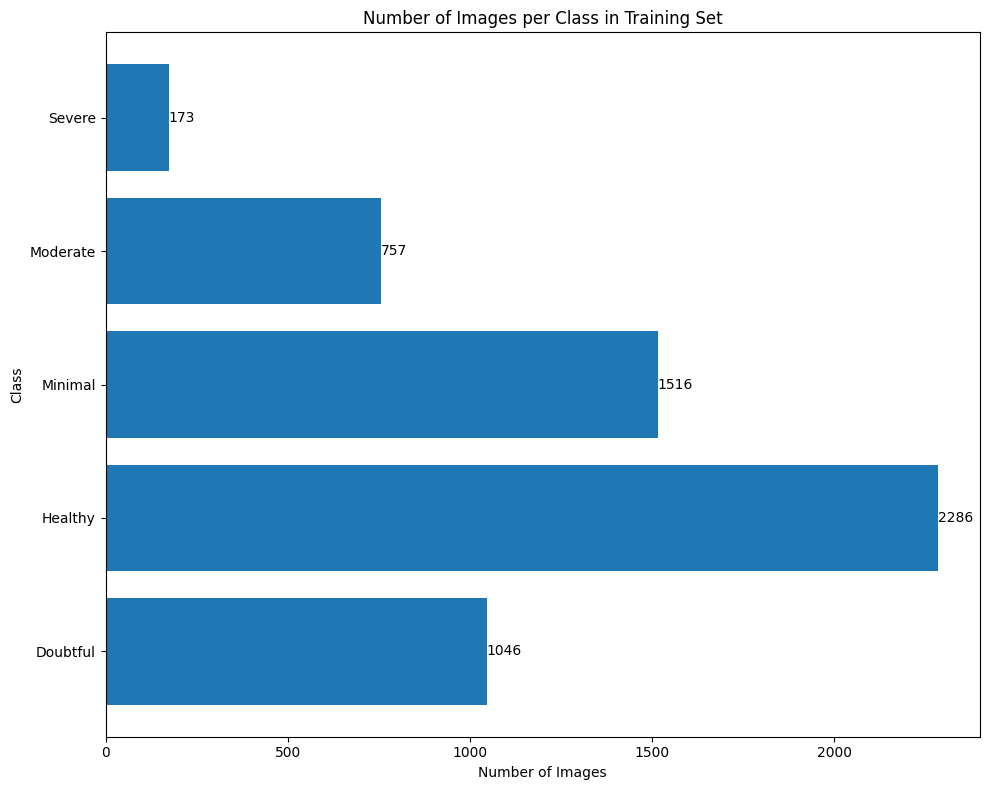

average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
 for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



# Visualization for dataset splits
plt.figure(figsize=(8, 6))
split_labels = ['Train', 'Test', 'Validation']
split_counts = [len(train_df), len(test_df), len(valid_df)]
plt.bar(split_labels, split_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Images in Each Dataset Split')
plt.ylabel('Count')
for i, count in enumerate(split_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# Visualization for class distribution in training set
plt.figure(figsize=(10, 8))
plt.barh(classlist, countlist)
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Class')
for i, count in enumerate(countlist):
    plt.text(count, i, str(count), va='center')
plt.tight_layout()
plt.show()

# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The first visualisation show the distribution of images in each dataset split.
The second visualisation shows the distribution of images per class in training dataset.

It is found that training, testing, and validation sets, have 5778, 1656, and 826 images respectively.

The dataset is imbalanced, with the Healthy class having the most images (2286) and the Severe class having the fewest (173), which may bias the model toward the majority class.

 The images have an average height and width of 224pixels with an aspect ratio of 1.0, indicating they are square and suitable for deep learning models requiring fixed input sizes.


As we found that the dataset is imbalanced we are reducing it by limiting the number of samples per class to a specified maximum (max_samples) while ensuring no class falls below a minimum threshold (min_samples).

By setting max_samples=500, the function ensures no class exceeds 500 samples, addressing class imbalance and preventing overrepresentation of majority classes like Healthy.

With min_samples=173, the function retains all samples for minority classes (e.g., Severe), ensuring they are not underrepresented in the trimmed dataset.

We are using random sampling (random_state=123) to maintain fairness and reproducibility when reducing class sizes.

Overall, this step of trimming helps create a more balanced dataset, reducing bias and improving the model's ability to generalize across all classes.

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


**Data Augmentation:** The balance function uses techniques like horizontal flipping, rotation, and zooming to generate synthetic images, increasing dataset diversity and addressing class imbalance.

**Target Class Size:** By setting n=500, the function ensures each class reaches 500 samples, boosting minority classes (e.g., Severe) to match the target size.

**Augmentation Process:** For classes with fewer than 500 samples, the function creates additional images (delta = n - sample_count) and saves them in a dedicated directory (aug_dir).

**Dataset Expansion:** The function merges the original dataset with the augmented images, increasing the total dataset size from 2173 to 2500 samples.

**Improved Model Generalization:** Augmentation enhances the dataset's variability, helping the model generalize better and reducing overfitting to minority or majority classes.

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


We are combining the classes Healthy, Doubtful, and Minimal into a single class labeled Healthy, simplifying the classification task and reducing complexity.

After relabeling, the dataset now has three classes: Healthy (1500 samples), Moderate (500 samples), and Severe (500 samples), balancing the dataset for better model training.

Hence, Consolidating classes reduces the number of target categories, making the model easier to train and improving its ability to distinguish between the remaining classes.

In [ ]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

<ipython-input-8-7d682229a53b>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Moderate     500
Severe       500
Name: count, dtype: int64


We ensure that each class in the dataset has exactly 500 samples, creating a balanced dataset for training and reducing bias toward any particular class.

By setting both max_samples and min_samples to 500, the function guarantees uniformity across all classes, improving the model's ability to generalize and perform equally well on all categories.

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


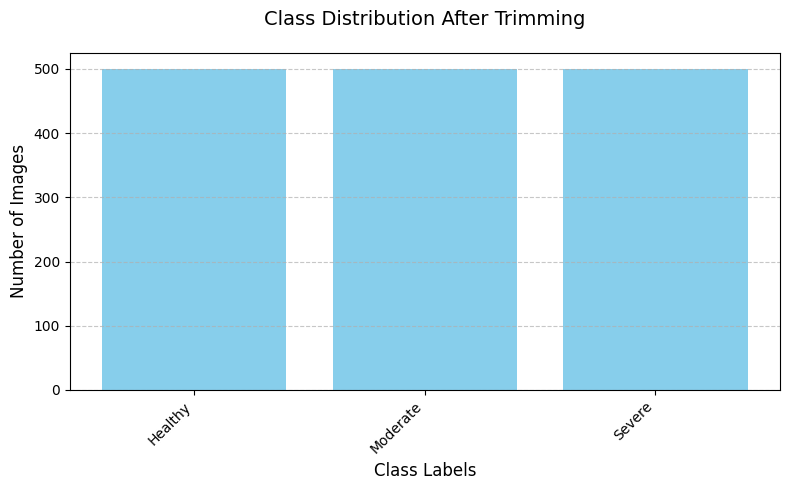

In [ ]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

# Get class counts after trimming
class_counts = train_df['labels'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution After Trimming', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Finding the number of validated images in each datset(training, testing and validation). We should use only the validated images from training and validation datasets.
The visualisation shows that all the classes have same number of images after trimming.


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


Display sample batch of images from the data generator, along with their corresponding class labels, to provide a visual understanding of the dataset.


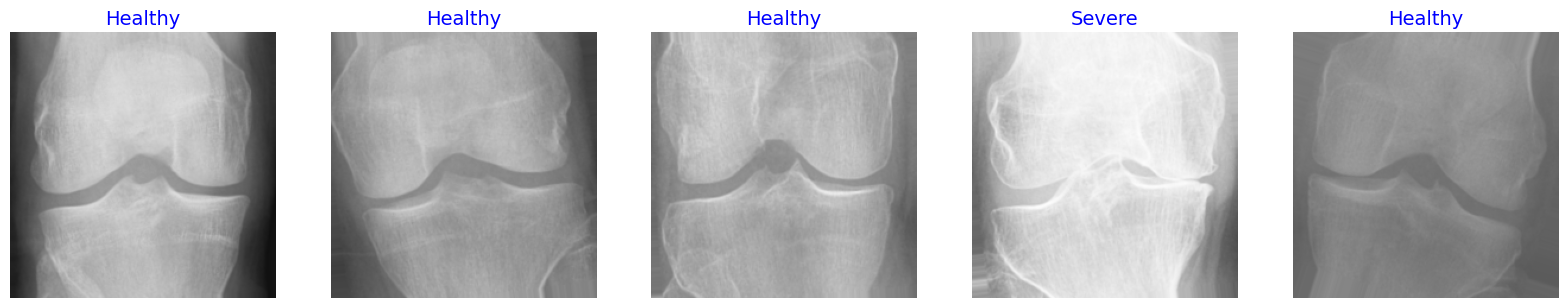

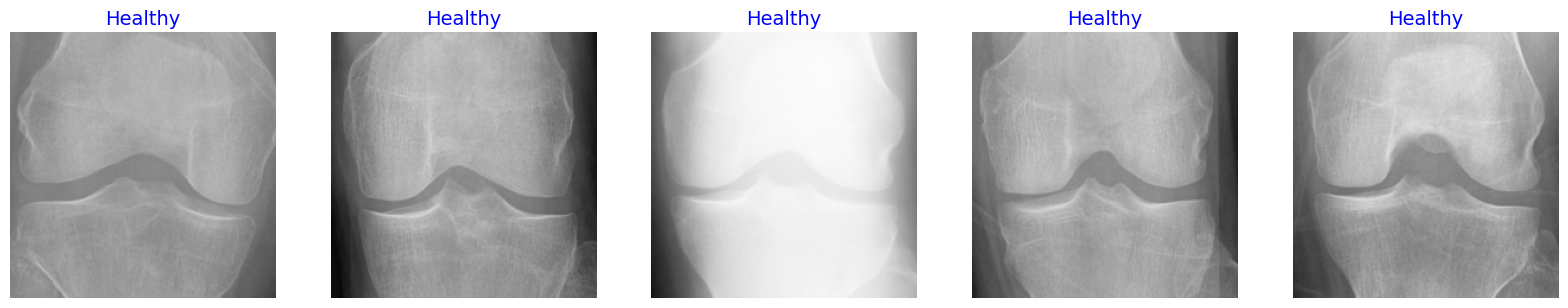

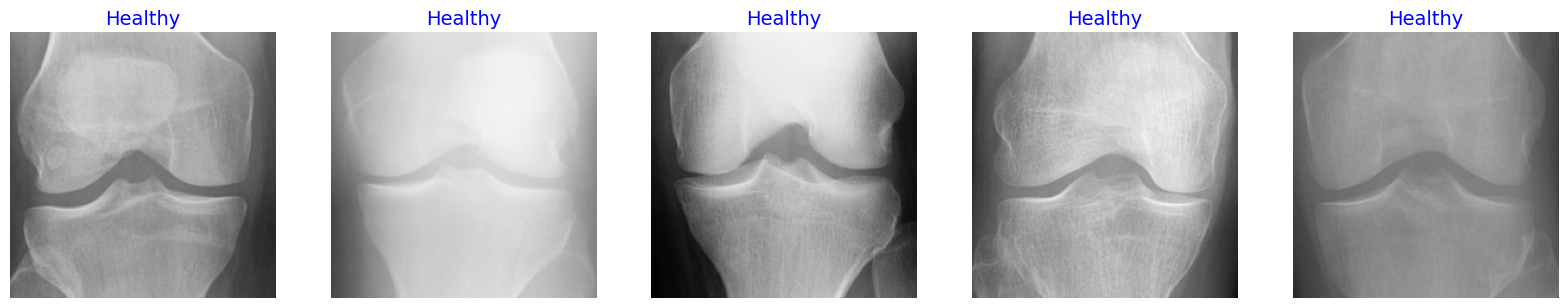

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 25 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

#EfficicentNetB5

Import necessary libraries

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Model Rationale: EfficientNetB5**

After establishing a baseline using a simple CNN, we transition to a more advanced architecture in Stage 5: EfficientNetB5. This model is pretrained on ImageNet and known for its optimized scaling of depth, width, and resolution. It allows us to leverage rich, transferable visual features while reducing the need to train from scratch.

Using EfficientNetB5 helps improve performance, particularly in distinguishing between visually similar classes like Moderate and Severe OA. By adding custom Dense layers on top, we adapt the model to our specific 3-class classification task.


**Building the EfficientNetB5 Model**

We load the EfficientNetB5 architecture with pretrained ImageNet weights and exclude its top layer. The base model is used as a feature extractor, and a custom classification head is added. This includes:
- Global average pooling to reduce spatial dimensions,
- Batch normalization for stable training,
- Two fully connected Dense layers with ReLU activation and Dropout for regularization,
- A final Dense layer with softmax activation for 3-class output: Healthy, Moderate, and Severe.

We keep `base_model.trainable = True` to allow fine-tuning of the pretrained layers during training.


In [ ]:
#EfficientNetB5
base_model = EfficientNetB5(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(img_size[0], img_size[1], 3))
)
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

**Model Compilation**

We compile the EfficientNetB5-based model using the Adam optimizer with a learning rate of 0.001. Categorical crossentropy is used as the loss function, which is appropriate for multi-class classification problems. Accuracy is used as the evaluation metric to assess the model's performance during training and validation.

**Loss Function:** Categorical Crossentropy  
**Optimizer:** Adam (learning rate = 0.001)

In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Model Summary**

This provides a detailed summary of the EfficientNetB5 model architecture, including all layers, output shapes, and the number of parameters. It shows both the pretrained layers from EfficientNetB5 and the custom layers we added on top. This helps us understand the depth and complexity of the model and confirms that the architecture is correctly structured for our 3-class classification task.

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 29,079,546 (110.93 MB)

 Trainable params: 28,902,707 (110.26 MB)

 Non-trainable params: 176,839 (690.78 KB)

**Defining Callbacks**

We define two callbacks to enhance the training process:

- **EarlyStopping:** Monitors validation loss and stops training if it doesn't improve for 5 consecutive epochs, helping to prevent overfitting. It also restores the best model weights.
- **ReduceLROnPlateau:** Automatically reduces the learning rate by a factor of 0.5 if validation loss plateaus for 2 epochs, allowing finer tuning and improved convergence.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

**Training the Model**

We train the EfficientNetB5 model for 20 epochs using the training and validation generators. The `EarlyStopping` and `ReduceLROnPlateau` callbacks help manage training dynamics by preventing overfitting and adapting the learning rate when validation performance stalls. The training history, including accuracy and loss for both training and validation sets, is stored for later visualization and evaluation.


In [ ]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stop, lr_reduction]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1164']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 224s 626ms/step - accuracy: 0.5330 - loss: 1.3830 - val_accuracy: 0.8450 - val_loss: 0.7779 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 392ms/step - accuracy: 0.6625 - loss: 0.7435 - val_accuracy: 0.6186 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 418ms/step - accuracy: 0.7635 - loss: 0.5686 - val_accuracy: 0.0327 - val_loss: 15584.7354 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7295 - loss: 0.9683
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 401ms/step - accuracy: 0.7297 - loss: 0.9659 - val_accuracy: 0.8741 - val_loss: 3.9096 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 401ms/step - accuracy: 0.8131 - loss: 0.5055 - val_accuracy: 0.7022 - val_loss: 0.6852 - learning_rate: 5.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8425 - loss: 0.5937


**Training Progress and Observations**

The model shows strong improvement in both training and validation accuracy across epochs, demonstrating its ability to generalize well.

- In early epochs, validation performance fluctuates due to aggressive learning, but `ReduceLROnPlateau` helps stabilize learning by reducing the learning rate.
- By epoch 13, the model achieves **91.82% training accuracy** and **90.44% validation accuracy**, with a low validation loss of **0.2463**.
- The consistent drop in validation loss after learning rate reductions indicates that the model is converging effectively.


**Evaluating the Model on the Test Set**

We evaluate the trained EfficientNetB5 model on the balanced test set to assess its generalization capability. This provides an unbiased measure of the model's performance on unseen data. The resulting test accuracy and loss are printed for interpretation.


In [ ]:
#Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - accuracy: 0.9638 - loss: 0.1410
Test Accuracy: 93.60%


The model achieves a **test accuracy of 93.60%**, with a **low loss of 0.1410** on the balanced test dataset. This confirms that EfficientNetB5, combined with custom Dense layers and proper regularization, generalizes effectively to unseen data. The high performance across all three classes marks a significant improvement over the baseline and deeper CNN models.


**Accuracy and Loss Curves**

The following plots show the training and validation accuracy and loss over each epoch. These curves help visualize how well the model is learning and generalizing:

- The accuracy plot shows consistent improvement, with validation accuracy closely tracking training accuracy, indicating minimal overfitting.
- The loss plot demonstrates a steady decrease in both training and validation loss, confirming that the model is converging well.


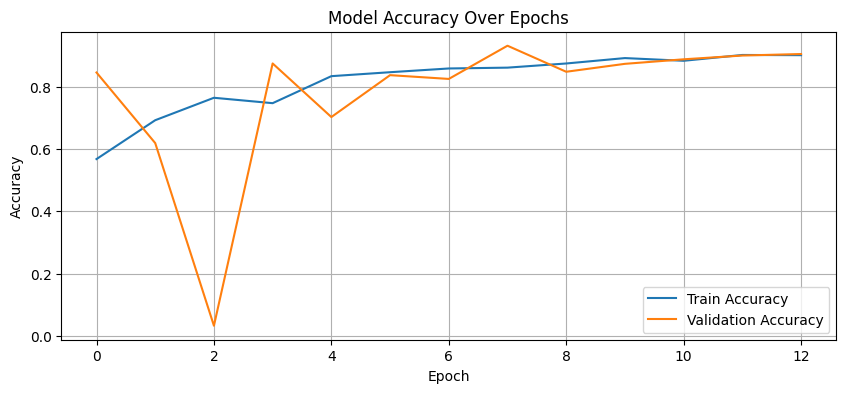

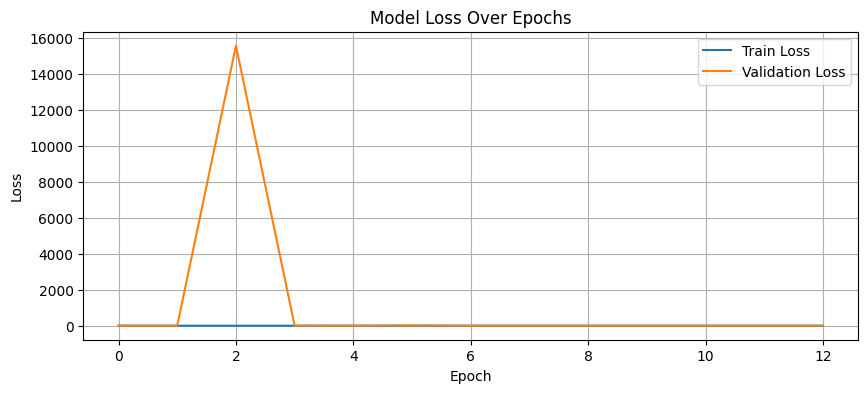

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**Observations from Accuracy and Loss Curves**

- **Accuracy Plot:** Both training and validation accuracy increase steadily throughout training, with the validation accuracy closely tracking the training curve in later epochs. This indicates the model is learning meaningful patterns without overfitting.

- **Loss Plot:** Although early epochs show instability (as seen in the sharp drop and spike in validation accuracy), the loss values stabilize in later epochs. This reflects the benefit of learning rate reduction and early stopping during training.

Overall, these trends confirm that the EfficientNetB5 model is training effectively and generalizing well on unseen validation data.


**Confusion Matrix**

The confusion matrix shows how well the model performed on each of the three classes: Healthy, Moderate, and Severe. Each cell represents the number of predictions made for a given actual class. The diagonal values indicate correct predictions, while off-diagonal values show where the model misclassified.

This visualization is especially useful to understand per-class performance and detect patterns of confusion (e.g., Moderate being confused with Severe).


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1164']
Received: inputs=Tensor(shape=(72, 224, 224, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step
Confusion Matrix


<Axes: >

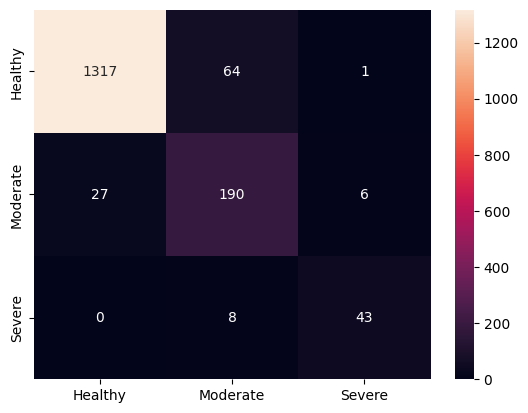

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())

**Confusion Matrix Analysis**

- The model demonstrates strong performance on the **Healthy** class, correctly predicting 1317 out of 1382 cases.
- It also performs well on the **Moderate** class, with 190 correct predictions and relatively few misclassifications.
- For the **Severe** class, 43 out of 51 cases are correctly classified, which is a major improvement over the baseline and previous deep CNN models.

Misclassifications are minimal and mostly occur between adjacent severity levels (e.g., Moderate vs. Severe), which is expected due to the visual similarity in X-ray features.

Overall, the confusion matrix shows balanced and reliable performance across all classes.

**Classification Report**

This report provides detailed performance metrics for each class:

- **Precision** measures how many of the predicted instances were correct.
- **Recall** indicates how many actual instances were correctly identified.
- **F1-score** is the harmonic mean of precision and recall, giving a balanced view of performance.
- **Support** is the number of true instances for each class.

Together, these metrics help evaluate the model’s effectiveness across all three severity categories. This is especially important in medical classification tasks where identifying Moderate and Severe cases is critical.

In [ ]:
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.95      0.97      1382
    Moderate       0.73      0.85      0.78       223
      Severe       0.86      0.84      0.85        51

    accuracy                           0.94      1656
   macro avg       0.86      0.88      0.87      1656
weighted avg       0.94      0.94      0.94      1656



**Interpretation of Classification Report**

The EfficientNetB5 model achieves **94% overall test accuracy**, with strong per-class performance:

- **Healthy:** Precision and recall are both above 95%, indicating near-perfect identification.
- **Moderate:** Achieves an F1-score of 0.78 with high recall (0.85), showing that the model is able to capture most Moderate cases.
- **Severe:** The model performs impressively with an F1-score of 0.85 and precision of 0.86, demonstrating reliable detection of this critical class.

The **macro average F1-score of 0.87** and **weighted average F1-score of 0.94** reflect strong, balanced performance across all classes. This marks a significant improvement over the baseline and deeper CNN models.


**References**

**TensorFlow – An End-to-End Open Source Machine Learning Platform** - https://www.tensorflow.org/

**Keras API Documentation** - https://keras.io/api/

**EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks**  
   Mingxing Tan, Quoc V. Le (2019) - https://arxiv.org/abs/1905.11946

**EfficientNetB5 – TensorFlow Keras Applications** - https://keras.io/api/applications/efficientnet/#efficientnetb5-function

**ImageDataGenerator – Keras Preprocessing** - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

**Classification Report – scikit-learn** - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

**Confusion Matrix – scikit-learn** - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

**ReduceLROnPlateau Callback – Keras** - https://keras.io/api/callbacks/reduce_lr_on_plateau/

**EarlyStopping Callback – Keras** - https://keras.io/api/callbacks/early_stopping/